# **Segmentation**
In this notebook, we will learn how to segment a image using watershed, normalized cuts, mean-shift algorithms.

---

In [1]:
import numpy as np
import cv2
import math
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### **Watershed algorithm**

#### Finding an approximate estimate of the coins


For that, we can use [`cv2.threshold`](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=threshold#threshold)

In [2]:
!wget -O water_coins.jpg "https://drive.google.com/u/1/uc?id=1zmvgQpHMJGQhXi0Po5D6QGl8P-scQCRt&export=download"

--2022-05-17 06:54:30--  https://drive.google.com/u/1/uc?id=1zmvgQpHMJGQhXi0Po5D6QGl8P-scQCRt&export=download
Resolving drive.google.com (drive.google.com)... 173.194.214.100, 173.194.214.139, 173.194.214.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.214.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1zmvgQpHMJGQhXi0Po5D6QGl8P-scQCRt&export=download [following]
--2022-05-17 06:54:30--  https://drive.google.com/uc?id=1zmvgQpHMJGQhXi0Po5D6QGl8P-scQCRt&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6b6eavlgqr59deltm8teke4rahgu93tr/1652770425000/03995330158540788625/*/1zmvgQpHMJGQhXi0Po5D6QGl8P-scQCRt?e=download [following]
--2022-05-17 06:54:30--  https://doc-00-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

In [3]:
img = Image.open('water_coins.jpg')
gray = img.convert('L')

img = np.asarray(img)
gray = np.asarray(gray)

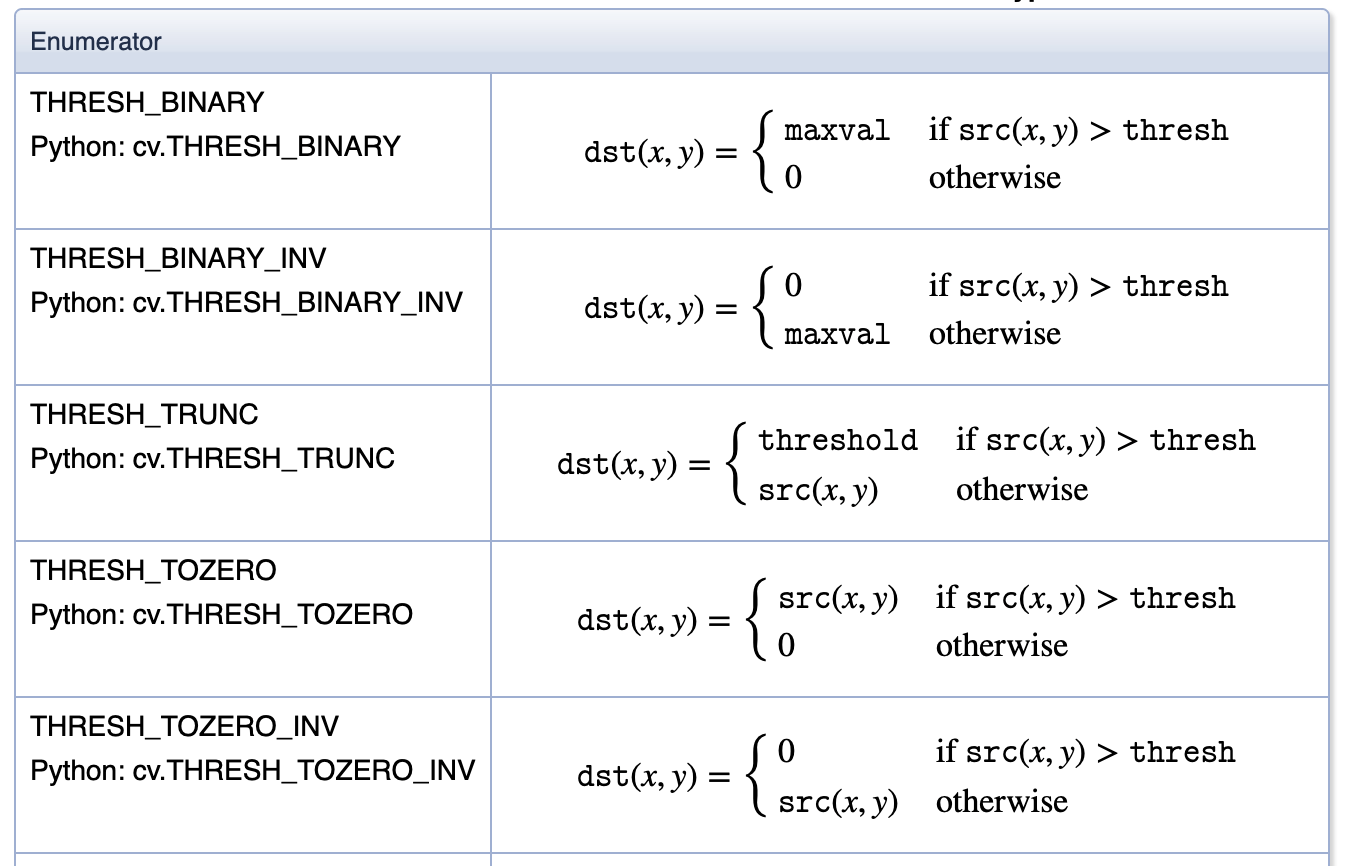

`ret, thresh = cv2.threshold(grayimg, thresh, maxval, method)`
- `input`
  - `grayimg`: input image (single-channel 8-bit or 32-bit floating point)
  - `thresh`: threshold value
  - `maxval`: maximum value to use with the `cv2.THRESH_BINARY` and `cv2.THRESH_BINARY_INV` thresholding method
  - `method`: thresholding types
    - `cv2.THRESH_BINARY`
    - `cv2.THRESH_BINARY_INV`
    - `cv2.THRESH_TRUNC`
    - `cv2.THRESH_TOZERO`
    - `cv2.THRESH_TOZERO_INV`
    - `cv2.THRESH_OTSU`
- `output`
  - `ret`: used threshold value.
  - `thresh`: thresholded image


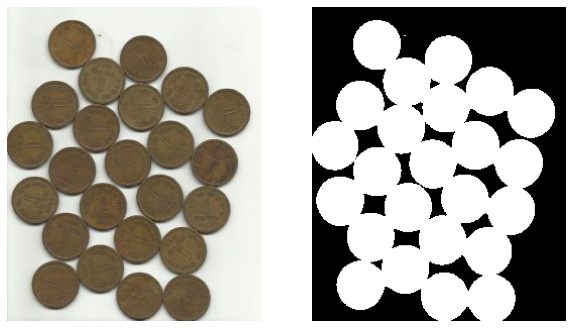

In [4]:
# TODO 1. find best config to get the mask of coins
thresh = 150 # your value
maxval = 255 # maximum value of mask
method = cv2.THRESH_BINARY_INV # method

ret, thresh = cv2.threshold(gray, thresh, maxval, method)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1); plt.imshow(img); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(thresh, cmap='gray'); plt.axis('off')
plt.show()

The special values `THRESH_OTSU` may be combined with one of the above values. In these cases, the function determines the optimal threshold value using the Otsu's algorithm and uses it instead of the specified thresh
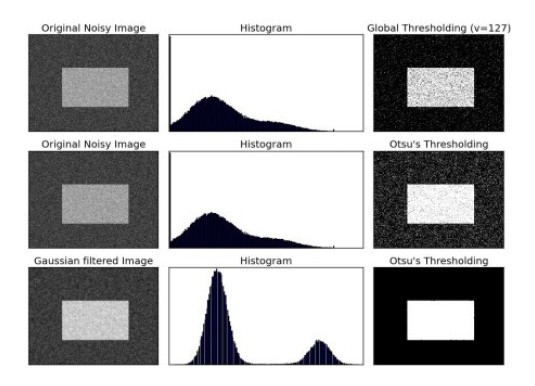

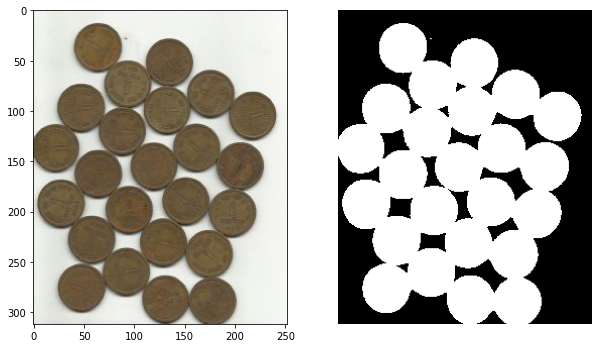

In [5]:
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

#### 2. Apply morphological transformations

Now we need to remove any small white noises in the image. For that we can use morphological transformations.

So, we first look at the morpholical transformations and apply it to our coin images.

In [6]:
!wget -O j.png "https://drive.google.com/u/1/uc?id=1JfRqvQmL_7Rq0RkYBDd9pZYNjyhQu3tP&export=download"

--2022-05-17 06:54:31--  https://drive.google.com/u/1/uc?id=1JfRqvQmL_7Rq0RkYBDd9pZYNjyhQu3tP&export=download
Resolving drive.google.com (drive.google.com)... 173.194.215.138, 173.194.215.100, 173.194.215.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1JfRqvQmL_7Rq0RkYBDd9pZYNjyhQu3tP&export=download [following]
--2022-05-17 06:54:31--  https://drive.google.com/uc?id=1JfRqvQmL_7Rq0RkYBDd9pZYNjyhQu3tP&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7a4uhiem4o86j79l69eeh7dvjvud2m63/1652770425000/03995330158540788625/*/1JfRqvQmL_7Rq0RkYBDd9pZYNjyhQu3tP?e=download [following]
--2022-05-17 06:54:32--  https://doc-0g-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

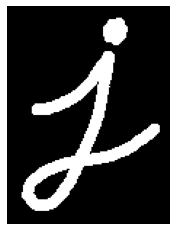

In [7]:
j_img = np.asarray(Image.open('j.png'))
plt.imshow(j_img, cmap='gray')
plt.axis('off')
plt.show()

#### (1) Erosion

The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object.

To do this, slide kernel through the image (as in 2D convolution).
A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero)

$𝚍𝚜𝚝(x,y)=min(x′,y′)_{𝚎𝚕𝚎𝚖𝚎𝚗𝚝(x′,y′)≠0} 𝚜𝚛𝚌(x+x′,y+y′)$

`dst = cv2.erode(src, kernel, anchor=(-1, -1), iterations=1, borderType=BORDER_CONSTANT, borderValue=morphologyDefaultBorderValue)`

- `input`
  - `src`: input image
  - `kernel`: structuring element used for erosion
  - `anchor`: position of the anchor within the element; default value (-1, -1) means that the anchor is at the element center.
  - `iterations`: number of times erosion is applied.
  - `borderType`: pixel extrapolation method
  - `borderValue`: border value in case of a constant border

- `output`
  - `dst`: output image

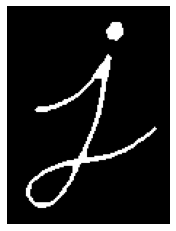

In [8]:
kernel = np.ones((5, 5), np.uint8)

erosion = cv2.erode(j_img, kernel, iterations=1)
plt.imshow(erosion, cmap='gray')
plt.axis('off')
plt.show()

#### (2) Dilation

It is just opposite of erosion.

Here, a pixel elementis '1' if atleast one pixel under the kernel is '1'

$𝚍𝚜𝚝(x,y)=max(x′,y′)_{𝚎𝚕𝚎𝚖𝚎𝚗𝚝(x′,y′)≠0} 𝚜𝚛𝚌(x+x′,y+y′)$

`dst = cv2.dilate(src, kernel, anchor=(-1, -1), iterations=1, borderType=BORDER_CONSTANT, borderValue=morphologyDefaultBorderValue)`

- `input`
  - `src`: input image
  - `kernel`: structuring element used for dilation
  - `anchor`: position of the anchor within the element; default value (-1, -1) means that the anchor is at the element center.
  - `iterations`: number of times dilation is applied.
  - `borderType`: pixel extrapolation method
  - `borderValue`: border value in case of a constant border

- `output`
  - `dst`: output image

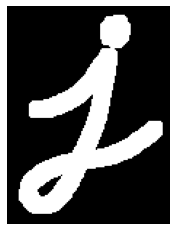

In [9]:
dilation = cv2.dilate(j_img, kernel, iterations = 1)
plt.imshow(dilation, cmap='gray')
plt.axis('off')
plt.show()

#### (3) Opening

Opening is just another name of **erosion followed by dilation**.
It is useful in removing noise.
Erosion removes white noises, but it also shrinks our object.
Sow we dilate it.

In [10]:
!wget -O opening.png "https://drive.google.com/u/1/uc?id=1lRIvHizy1rDfyh6aFGmJdYX5poihWqtI&export=download"

--2022-05-17 06:54:32--  https://drive.google.com/u/1/uc?id=1lRIvHizy1rDfyh6aFGmJdYX5poihWqtI&export=download
Resolving drive.google.com (drive.google.com)... 173.194.215.101, 173.194.215.138, 173.194.215.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1lRIvHizy1rDfyh6aFGmJdYX5poihWqtI&export=download [following]
--2022-05-17 06:54:32--  https://drive.google.com/uc?id=1lRIvHizy1rDfyh6aFGmJdYX5poihWqtI&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ida58bu8fj3vjsum79032mpadu81m5oe/1652770425000/03995330158540788625/*/1lRIvHizy1rDfyh6aFGmJdYX5poihWqtI?e=download [following]
--2022-05-17 06:54:33--  https://doc-04-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

The function `cv2.morphologyEx` can perform advanced morphological transformations using an erosion and dilation as basic operations.

`dst = cv2.morphologyEx(src, op, anchor=(-1, -1), iterations=1, borderType=BORDER_CONSTANT, borderValue=morphologyDefaultBorderValue)`

- `input`
  - `src`: input image
  - `op`: structuring element used for erosion
    - `MORPH_ERODE`: erode
    - `MORPH_DILATE`: dilate
    - `MORPH_OPEN`: opening (erode -> dilate)
    - `MORPH_CLOSE`: closing (dilate -> erode)
    - `MORPH_GRADIENT`: morphological gradient (dilate - erode)
    - `MORPH_TOPHAT`: top hat (src - open)
    - `MORPH_BLACKHAT`: black hat (close - src)
  - `kernel`: structuring element
  - `anchor`: position of the anchor within the element; default value (-1, -1) means that the anchor is at the element center.
  - `iterations`: number of times erosion is applied.
  - `borderType`: pixel extrapolation method
  - `borderValue`: border value in case of a constant border

- `output`
  - `dst`: output image

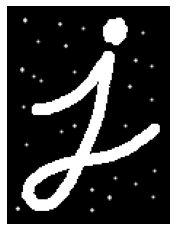

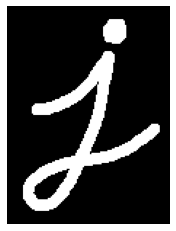

In [11]:
opening_img = np.asarray(Image.open('opening.png'))[:, :112]
plt.figure()
plt.imshow(opening_img, cmap='gray')
plt.axis('off')
plt.show()

opening = cv2.morphologyEx(opening_img, cv2.MORPH_OPEN, kernel)
plt.figure()
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.show()

#### (4) Closing

Closing is reverse of Opening, **Dilation followed by Erosion**.
It is useful in closing small holes inside the foreground objects, or small black points on the object.

In [12]:
!wget -O closing.png "https://drive.google.com/u/1/uc?id=1av0MtM5Lsf2cMDrQKwNsUn-OcCtjCKy2&export=download"

--2022-05-17 06:54:33--  https://drive.google.com/u/1/uc?id=1av0MtM5Lsf2cMDrQKwNsUn-OcCtjCKy2&export=download
Resolving drive.google.com (drive.google.com)... 173.194.216.102, 173.194.216.138, 173.194.216.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1av0MtM5Lsf2cMDrQKwNsUn-OcCtjCKy2&export=download [following]
--2022-05-17 06:54:33--  https://drive.google.com/uc?id=1av0MtM5Lsf2cMDrQKwNsUn-OcCtjCKy2&export=download
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hd91s89iaeajgrfd1ed4umpkhqb67pt0/1652770425000/03995330158540788625/*/1av0MtM5Lsf2cMDrQKwNsUn-OcCtjCKy2?e=download [following]
--2022-05-17 06:54:33--  https://doc-00-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

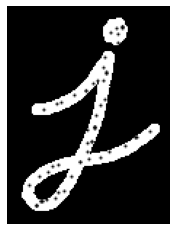

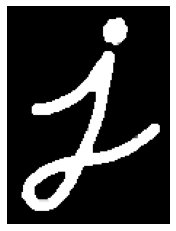

In [13]:
closing_img = np.asarray(Image.open('closing.png'))[:, :112]
plt.figure()
plt.imshow(closing_img, cmap='gray')
plt.axis('off')
plt.show()

closing = cv2.morphologyEx(closing_img, cv2.MORPH_CLOSE, kernel)
plt.figure()
plt.imshow(closing, cmap='gray')
plt.axis('off')
plt.show()

Now, let's apply morphological transformation to our images!

![watershed](https://www.researchgate.net/publication/349323744/figure/fig2/AS:991524607258625@1613409296245/The-segmentation-process-of-the-watershed-algorithm.ppm)

First, remove noise and plot

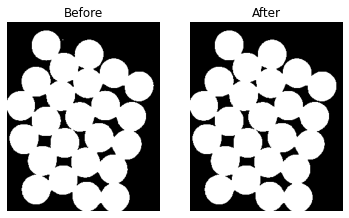

In [14]:
# Noise removal
img = Image.open('water_coins.jpg')
img = img.convert('L')
img = np.asarray(img)

# TODO 1. define kernel you want to use for morphological transformation
kernel = np.ones((3,3), np.uint8)

# TODO 2. find best threshold for masking coin and get thresholded image
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# TODO 3. get noise removed thresholded image by using morphological transformation
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.subplot(1, 2, 1); plt.imshow(thresh, cmap='gray'); plt.title('Before'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(opening, cmap='gray'); plt.title('After'); plt.axis('off')
plt.show()

Then, extract sure background areas

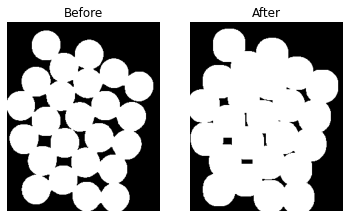

In [15]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.subplot(1, 2, 1); plt.imshow(opening, cmap='gray'); plt.title('Before'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(sure_bg, cmap='gray'); plt.title('After'); plt.axis('off')
plt.show()

We need to extract the area which we are sure they are coins.
Erosion removes the boundary pixels.
So whatever remaining, we can be sure it is coin.
But since they are touching each other, another good option would be to find the distance transform and apply a proper threshold.

We will use [dst = `cv2.distanceTransform(src, distanceType, maskSize)'](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#distancetransform)

It Calculates the distance to the closest zero pixel for each pixel of the source image.

Args
- `src`: 8-bit, single-channel source image
- `distanceType`: Type of distance. It can be `cv2.CV_DIST_L1`, `cv2.CV_DIST_L2`, `cv2.CV_DIST_C`
- `maskSize`: Size of the distance transform mask. It can be 3 or 5

Returns
- `dst`: Output image with calculated distances

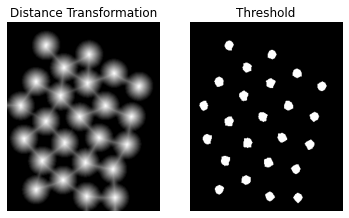

In [16]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, cv2.THRESH_BINARY)

plt.subplot(1,2,1); plt.imshow(dist_transform, cmap='gray'); plt.title('Distance Transformation'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(sure_fg, cmap='gray'); plt.title('Threshold'); plt.axis('off')
plt.show()

The remaining regions are those which we don't have any idea, whether it is coins or background.
Watershed algorithm should find it.

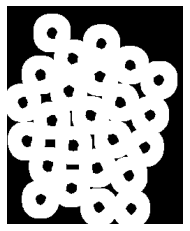

In [17]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap='gray')
plt.axis('off')
plt.show()

Now we create marker and label the regions inside it.
We will use `cv2.connectedComponents()`.
It labels background of the image with 0, then other objects are labelled with integers starting from 1

computes the connected components labeled image of boolean image
`retval, labels = cv2.connectedComponents(src)`
- `input`
  - `src`: input image

- `output`
  - `retval`: the total number of labels
  - `labels`: [0, N-1] where 0 represents the background label.


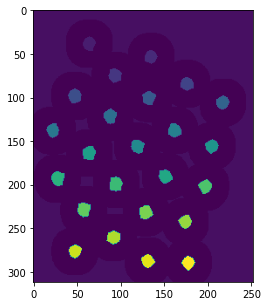

In [18]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=(7,5))
plt.imshow(markers)
plt.show()

Now our marker is ready.
It is time for final step, apply watershed.
The boundary region will be marked with -1.

Performs a marker-based image segmentation using the watershed algorithm.
`markers = cv2.watershed(img, markers)`
- `input`
  - `img`: input image
  - `markers`: roughly outline the desired regions in the image

- `output`
  - `markers`: new markers. -1 means boundaries between regions

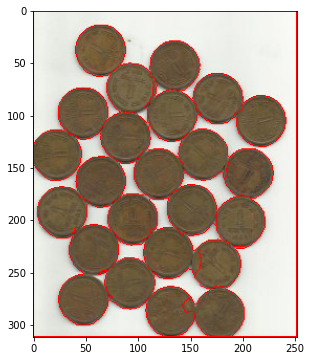

In [19]:
img = np.asarray(Image.open('water_coins.jpg'))
markers = cv2.watershed(img,markers)
final = img.copy()
final[markers == -1] = [255,0,0]

plt.figure(figsize=(5, 6))
plt.imshow(final)
plt.show()

## Active Contour

The active contour model is a method to fit open or closed splines to lines or edges in an image 1. It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy.

We will use scikit-image library to run a simple example of Active Contour.

Reference: https://scikit-image.org/docs/dev/api/skimage.segmentation.html#active-contour

In [20]:
!pip install scikit-image==0.18
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

     |████████████████████████████████| 29.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


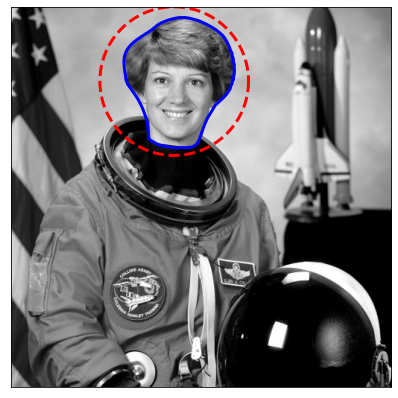

In [21]:
img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()